Convolution Autoencoders
======

In [125]:
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [126]:
num_epochs = 50
batch_size = 128
capacity = 1
learning_rate = 1e-2
use_gpu = True

Data Loading
-------------------

Screenshots show in 16x16 images. We normalize them, which gives a slight performance boost during training.
We create both a training set and a test set.

In [127]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Dataset Construct
-------------------

As problem 1.

In [128]:

class DatasetFromCSV(Dataset):
    def __init__(self, csv_path, height=16, width=16, transforms=None):
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 256])
        self.height = height
        self.width = width
        self.transforms = transforms
 
    def __getitem__(self, index):
        single_image_label = self.labels[index]
        # 1D array ([256]) reshape -> 2D array ([16,16])
        img_as_np = np.asarray(self.data.iloc[index][0:256]).reshape(16, 16, 1).astype(float)

        #print("img_as_np:",img_as_np.shape[0],img_as_np.shape[1],img_as_np.shape[2])
        
        # transform numpy to tensor
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_np)
            img_as_tensor = img_as_tensor.type(torch.FloatTensor)
        #print(img_as_tensor.type())
        #print("img_as_tensor:",img_as_tensor.shape[0],img_as_tensor.shape[1],img_as_tensor.shape[2])
        return (img_as_tensor, single_image_label)
 
    def __len__(self):
        return len(self.data.index)


In [129]:
train_dataset= DatasetFromCSV('trainingdata.csv',16,16,img_transform)
test_dataset = DatasetFromCSV("testingdata.csv",16,16,img_transform)
 
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=True, num_workers=0)


Autoencoder Definition
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in second convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems.

In [130]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 8 x 8
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: 2c x 4 x 4
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = x.view(x.size(0), capacity*2, 4, 4) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)
print("Encoder:", Encoder())

Number of parameters: 101
Encoder: Encoder(
  (conv1): Conv2d(1, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


Train Autoencoder
--------

In [131]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 1.094431
Epoch [2 / 50] average reconstruction error: 1.060625
Epoch [3 / 50] average reconstruction error: 1.040393
Epoch [4 / 50] average reconstruction error: 1.030890
Epoch [5 / 50] average reconstruction error: 1.027802
Epoch [6 / 50] average reconstruction error: 1.027372
Epoch [7 / 50] average reconstruction error: 1.027503
Epoch [8 / 50] average reconstruction error: 1.027525
Epoch [9 / 50] average reconstruction error: 1.027444
Epoch [10 / 50] average reconstruction error: 1.027372
Epoch [11 / 50] average reconstruction error: 1.027346
Epoch [12 / 50] average reconstruction error: 1.027345
Epoch [13 / 50] average reconstruction error: 1.027346
Epoch [14 / 50] average reconstruction error: 1.027345
Epoch [15 / 50] average reconstruction error: 1.027344
Epoch [16 / 50] average reconstruction error: 1.027344
Epoch [17 / 50] average reconstruction error: 1.027344
Epoch [18 / 50] average reconstruction error: 1.027344
Epoch 

In [132]:
save_path = './pretrained/autoencoder_v2_conv.pth'
torch.save(autoencoder.state_dict(), save_path)

Plot Training Curve
--------------------

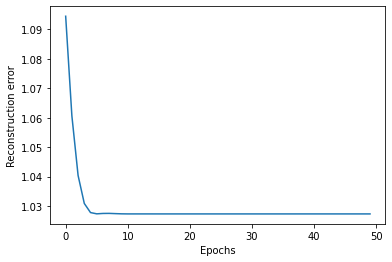

In [133]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Load Pre-Trained Autoencoder
-----------------------------

In [134]:
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('importing ...')
autoencoder.load_state_dict(torch.load('./pretrained/autoencoder_v2_conv.pth'))
print('done')

importing ...
done


Evaluate on the Test Set
-------------------------

In [135]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():

        image_batch = image_batch.to(device)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 1.027344
